FORECAST - Autoregressive methods

In [1]:
import pandas as pd
from pandas import Series
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import matplotlib
import matplotlib.pyplot as plt

import itertools
import numpy as np
import datetime

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller    
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

matplotlib.rcParams['figure.figsize'] = 33, 13
import ml_metrics as metrics
import warnings


# Visualize the time series

In [2]:
def dateparse(time):
    return datetime.datetime.fromtimestamp(float(time)/1000)
dataset = pd.read_csv('data/[1h]BTCUSDT.csv', parse_dates=['Start', 'Stop'], date_parser=dateparse)

dataset.head()


,Start,Stop,Open,Close,Low,High,Volume
0,2017-08-17 07:00:00,2017-08-17 07:59:59.999,4261.48,4308.83,4261.32,4313.62,47.181009
1,2017-08-17 08:00:00,2017-08-17 08:59:59.999,4308.83,4315.32,4291.37,4328.69,23.234916
2,2017-08-17 09:00:00,2017-08-17 09:59:59.999,4330.29,4324.35,4309.37,4345.45,7.229691
3,2017-08-17 10:00:00,2017-08-17 10:59:59.999,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 11:00:00,2017-08-17 11:59:59.999,4333.32,4360.69,4333.32,4377.85,0.972807


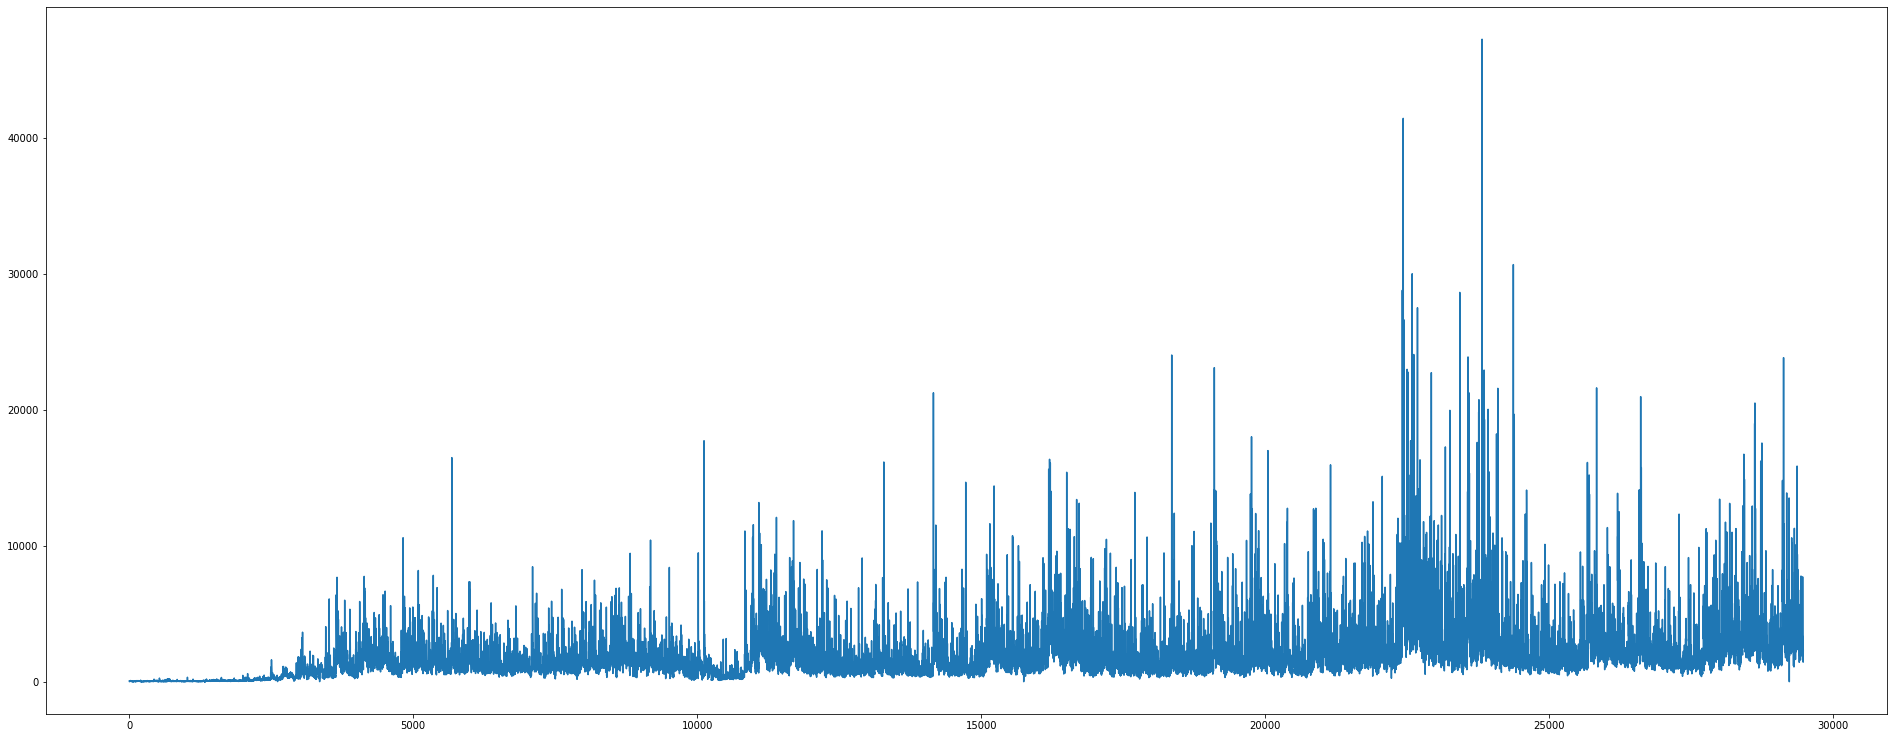

In [3]:
plt.figure(figsize=(33, 13))
plt.plot(dataset.Volume)

# Rolling window estimations

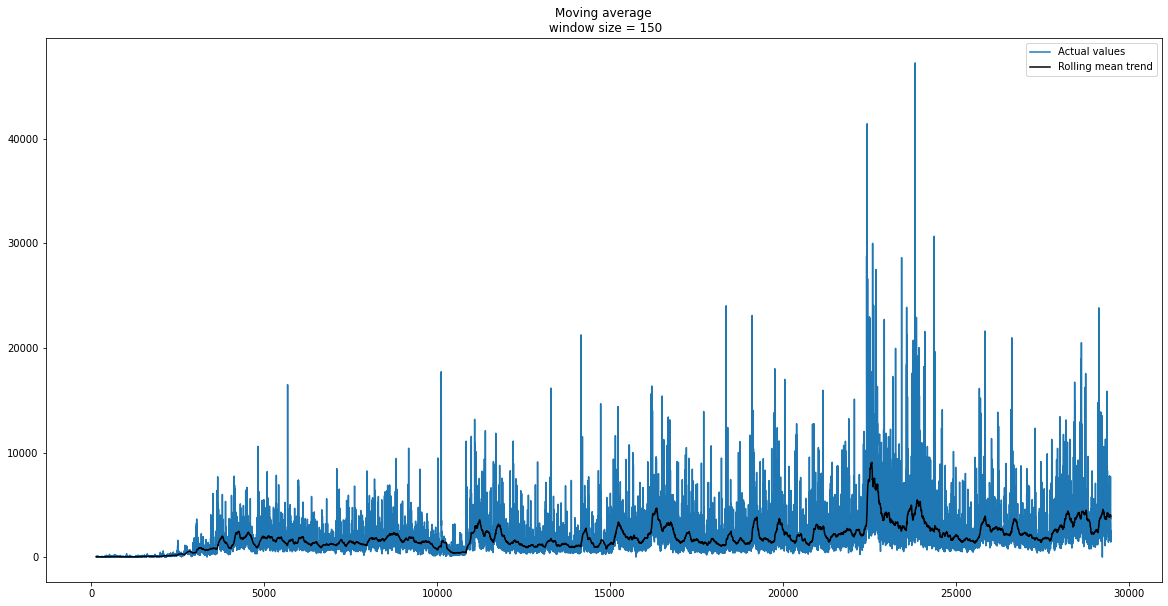

In [4]:
rolling_mean = dataset.Volume.rolling(window=150).mean()
plt.figure(figsize=(20, 10))
plt.title("Moving average\n window size = {}".format(150))
plt.plot(dataset.Volume[150:], label="Actual values")
plt.plot(rolling_mean, "black", label="Rolling mean trend")
plt.legend()

# Time-series decomposition

<AxesSubplot:xlabel='Stop'>

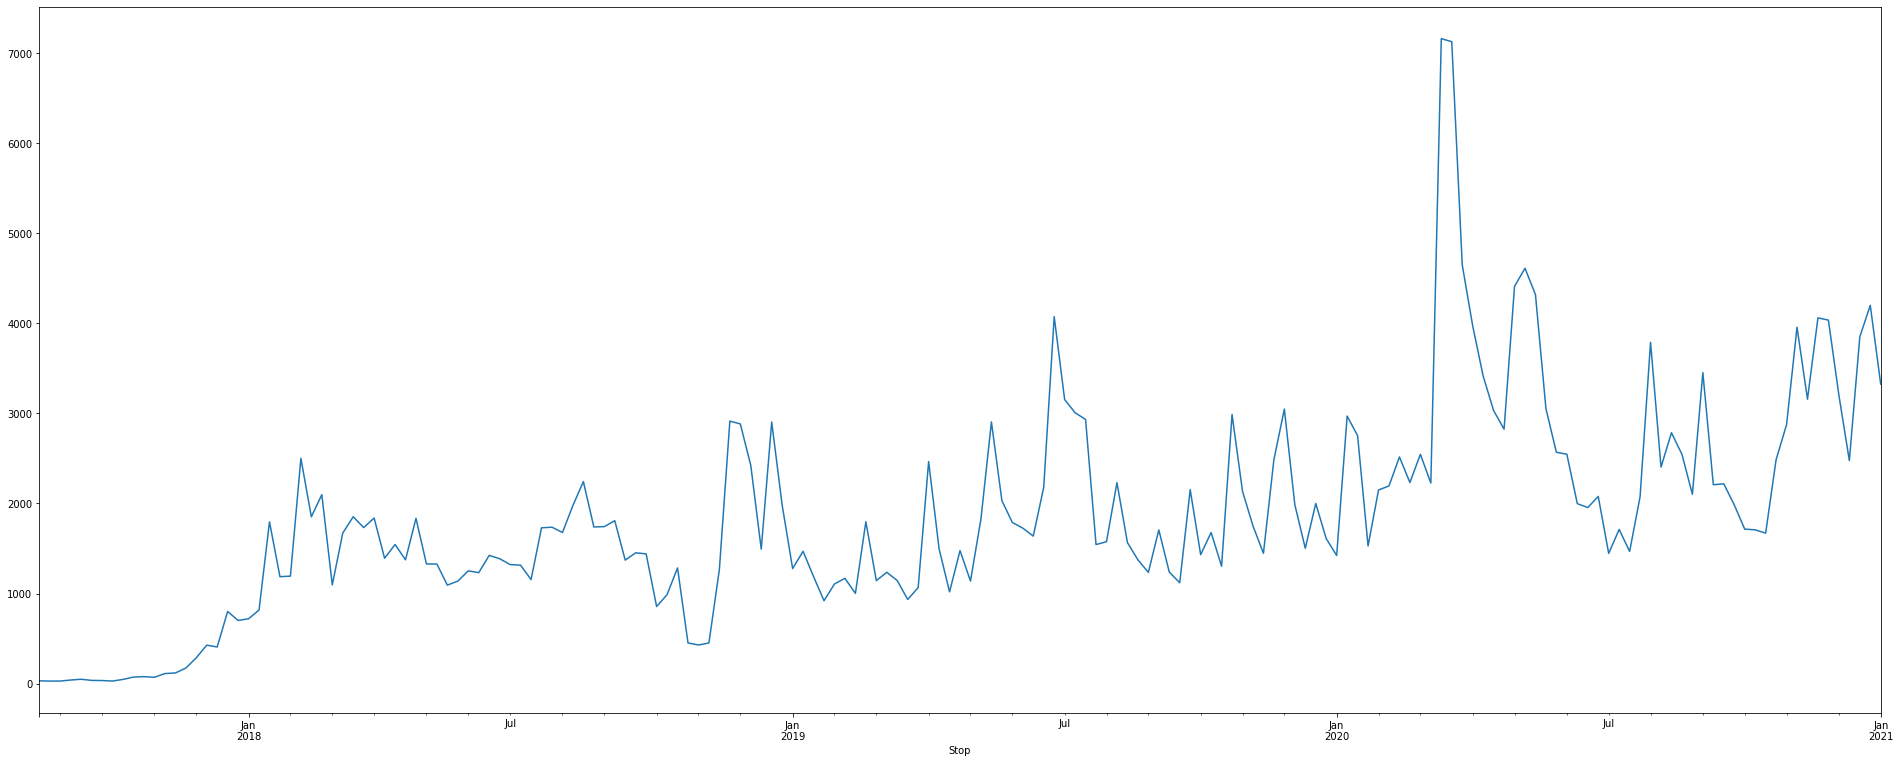

In [5]:
dataset_copy = dataset.copy()
dataset_copy = dataset_copy.set_index('Stop')
y = dataset_copy.Volume.resample('W').mean()
y.plot(figsize=(33, 13))

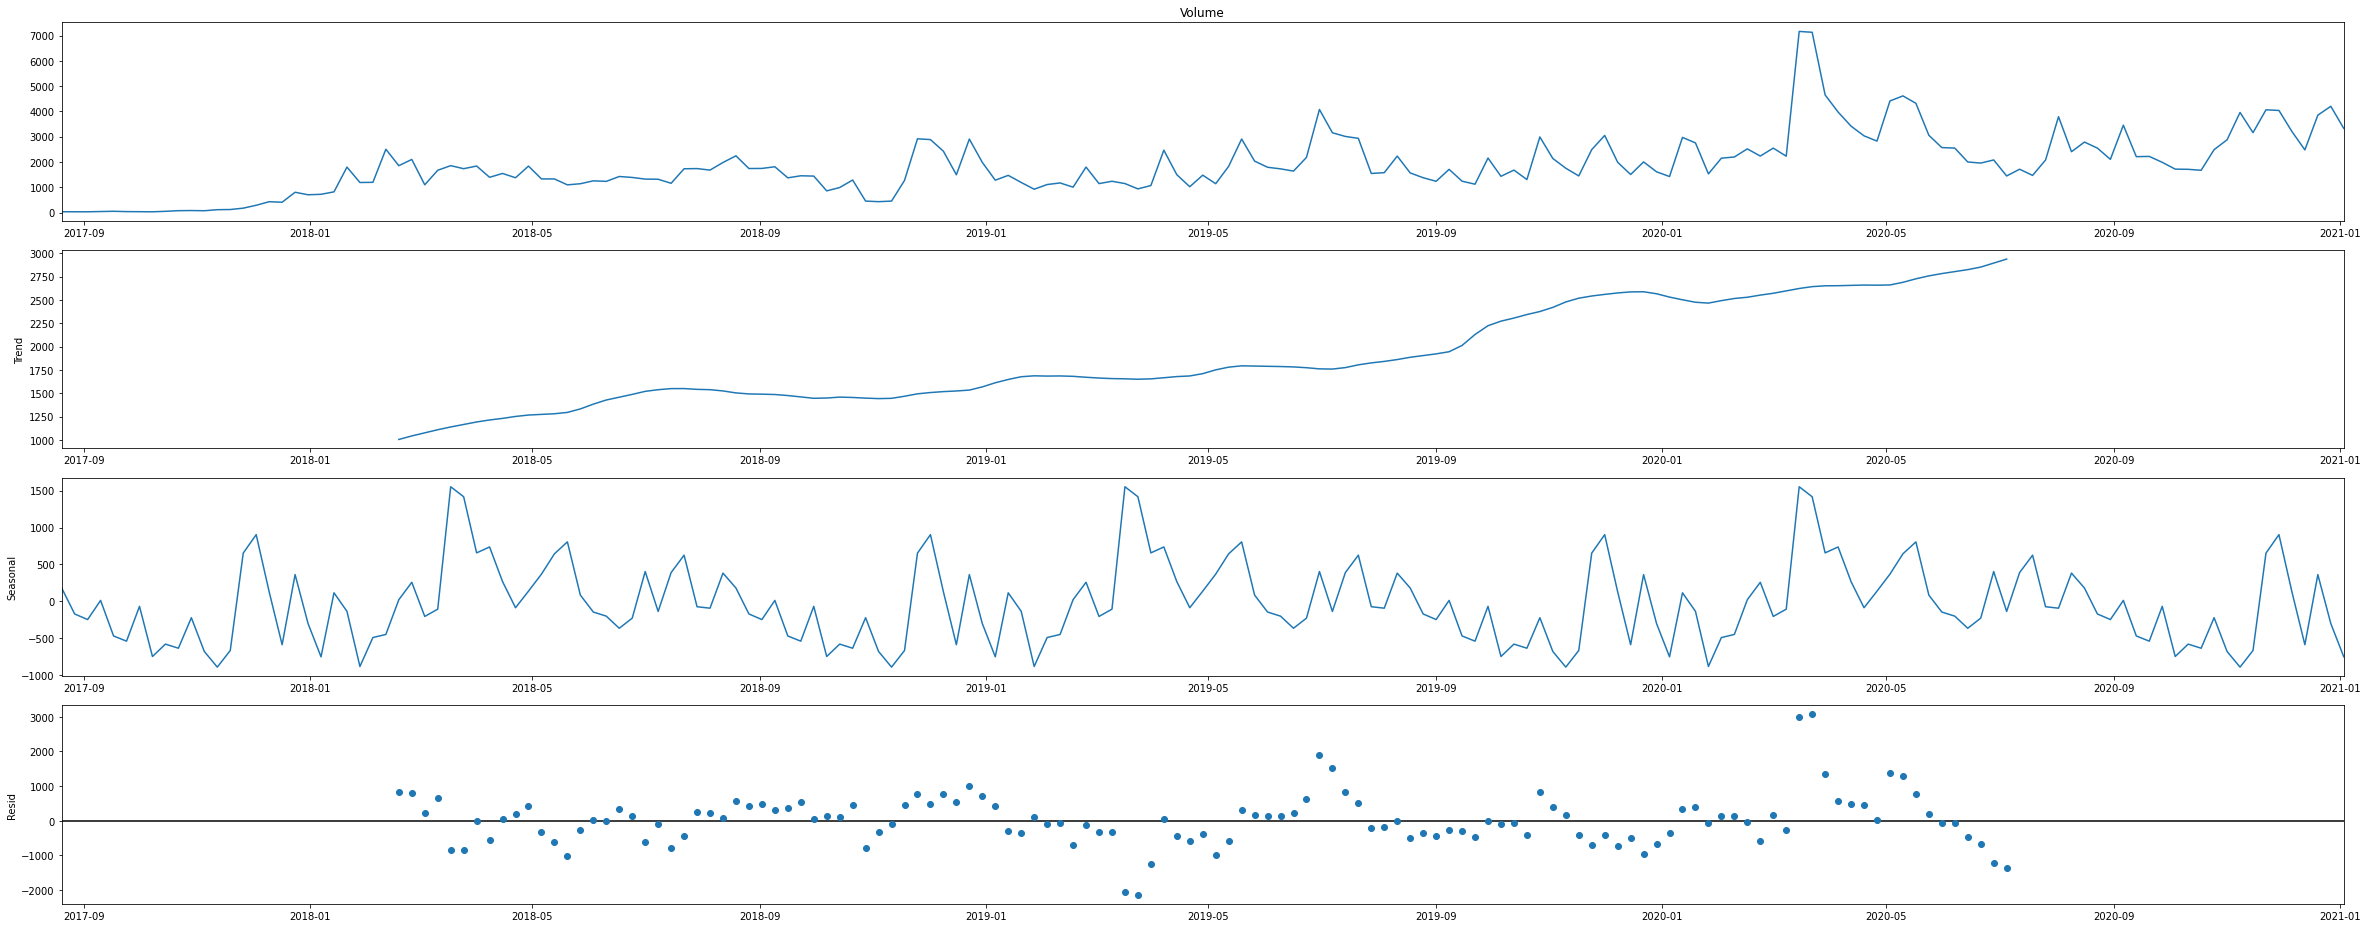

In [6]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

<AxesSubplot:>

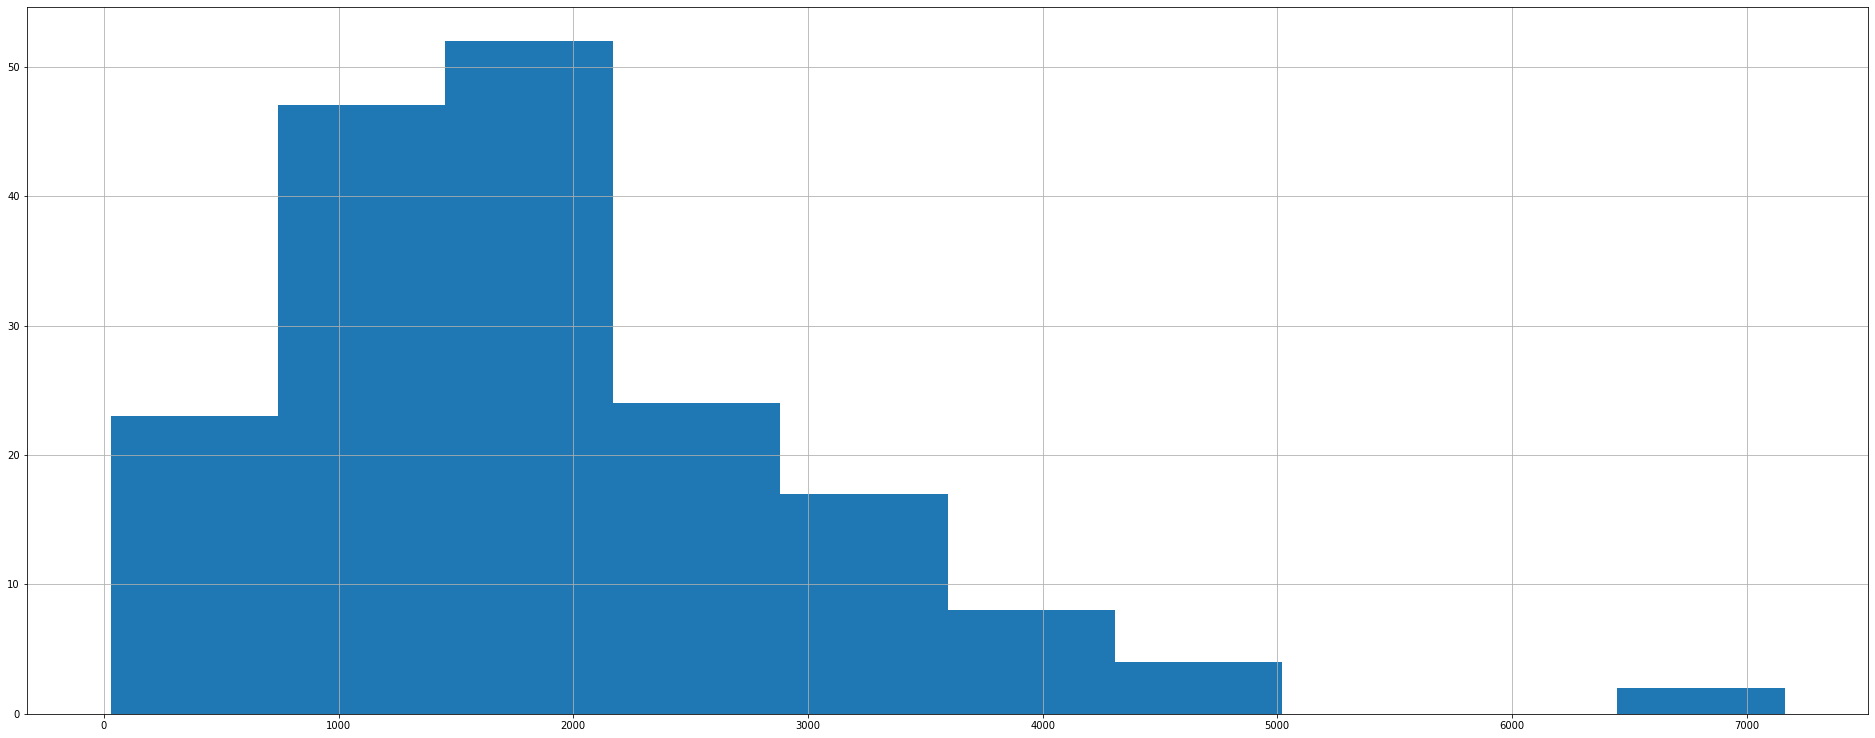

In [7]:
y.hist()


# Autocorrelation

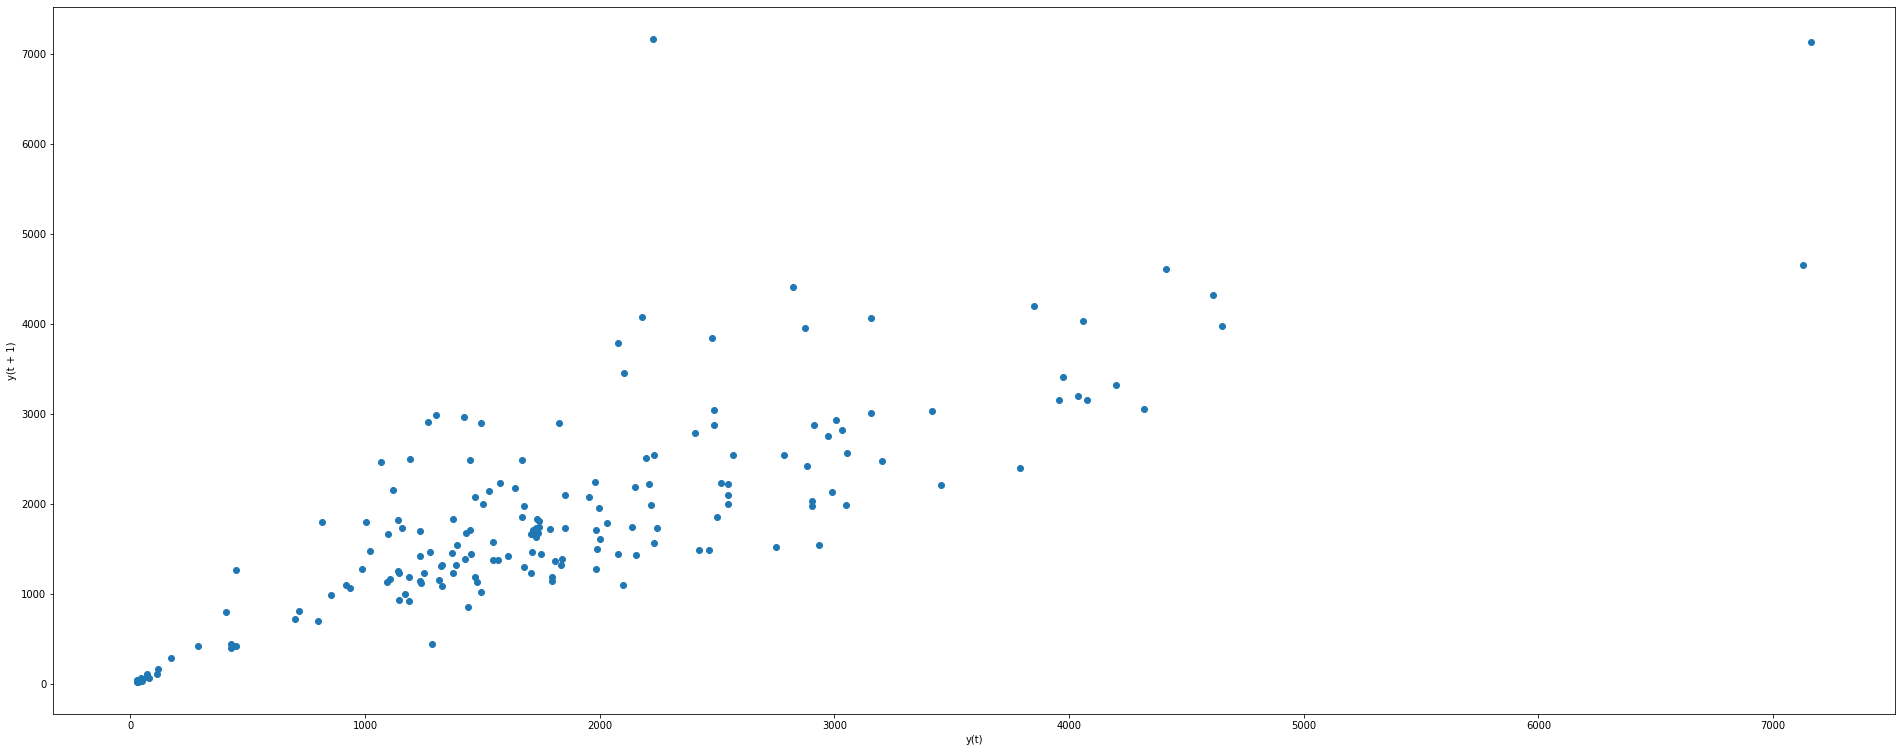

In [8]:
series = Series(data=y)
lag_plot(series)
plt.show()

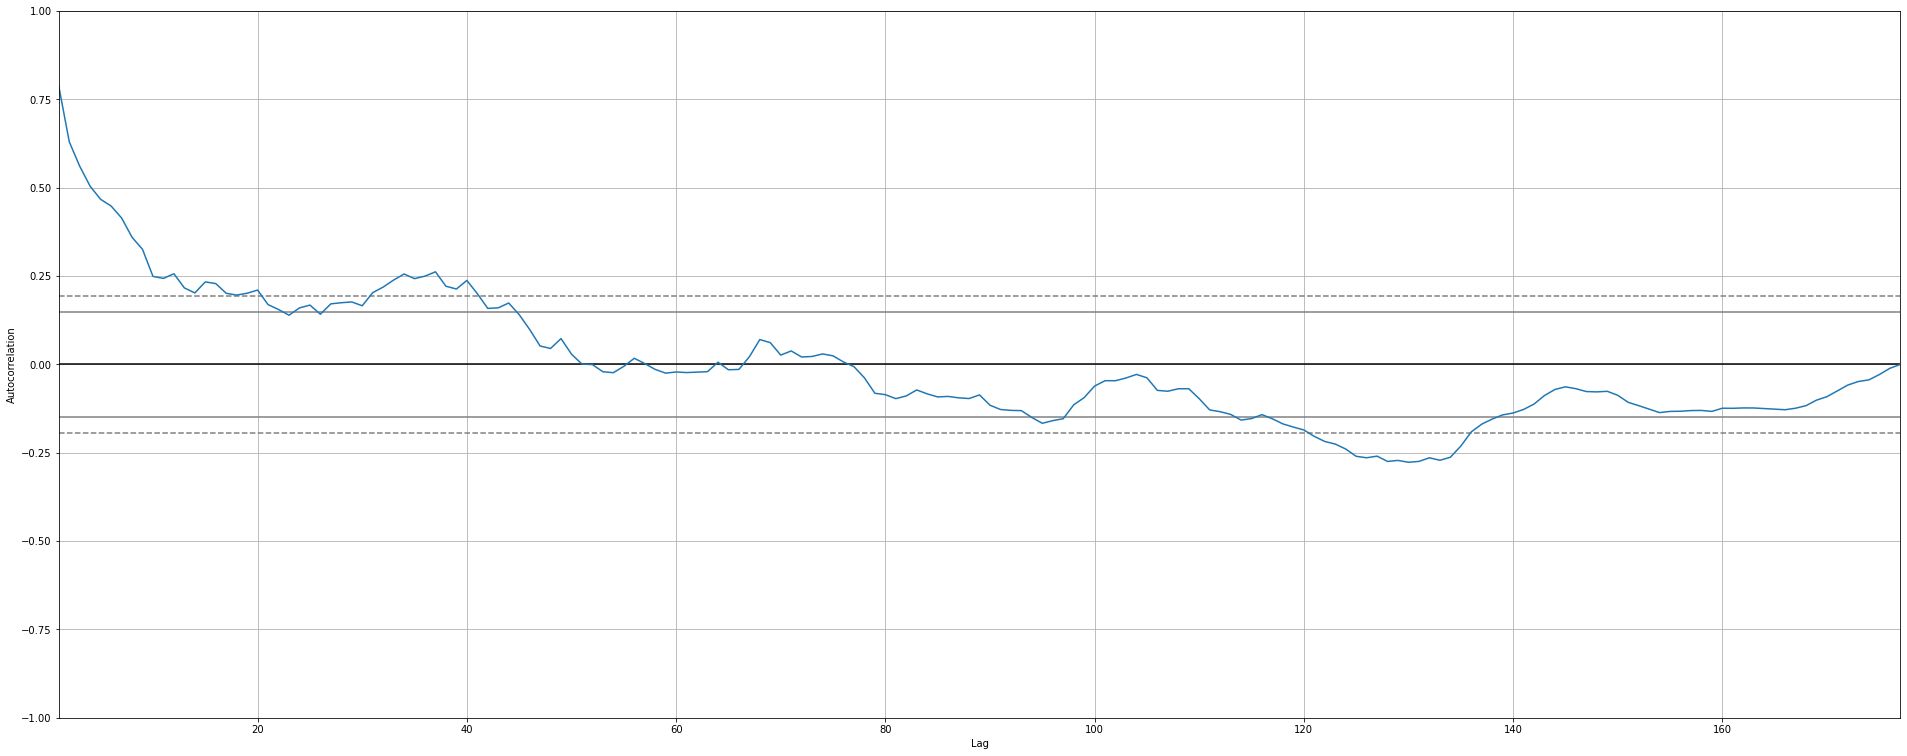

In [9]:
series = Series(data=y)
autocorrelation_plot(series)
plt.show()

# Stationarize the time series

In [10]:
test = adfuller(y)
print("ADF Statistic: {0}".format(test[0]))
print("p-value: {0}".format(test[1]))

if test[0] < test[4]["5%"]:
    print ("\nStationary")
else:
    print ("\nNon-Stationary")

ADF Statistic: -4.5014813226348345
p-value: 0.00019543152987510593

Stationary


# Plot ACF/PACF charts and find optimal parameters

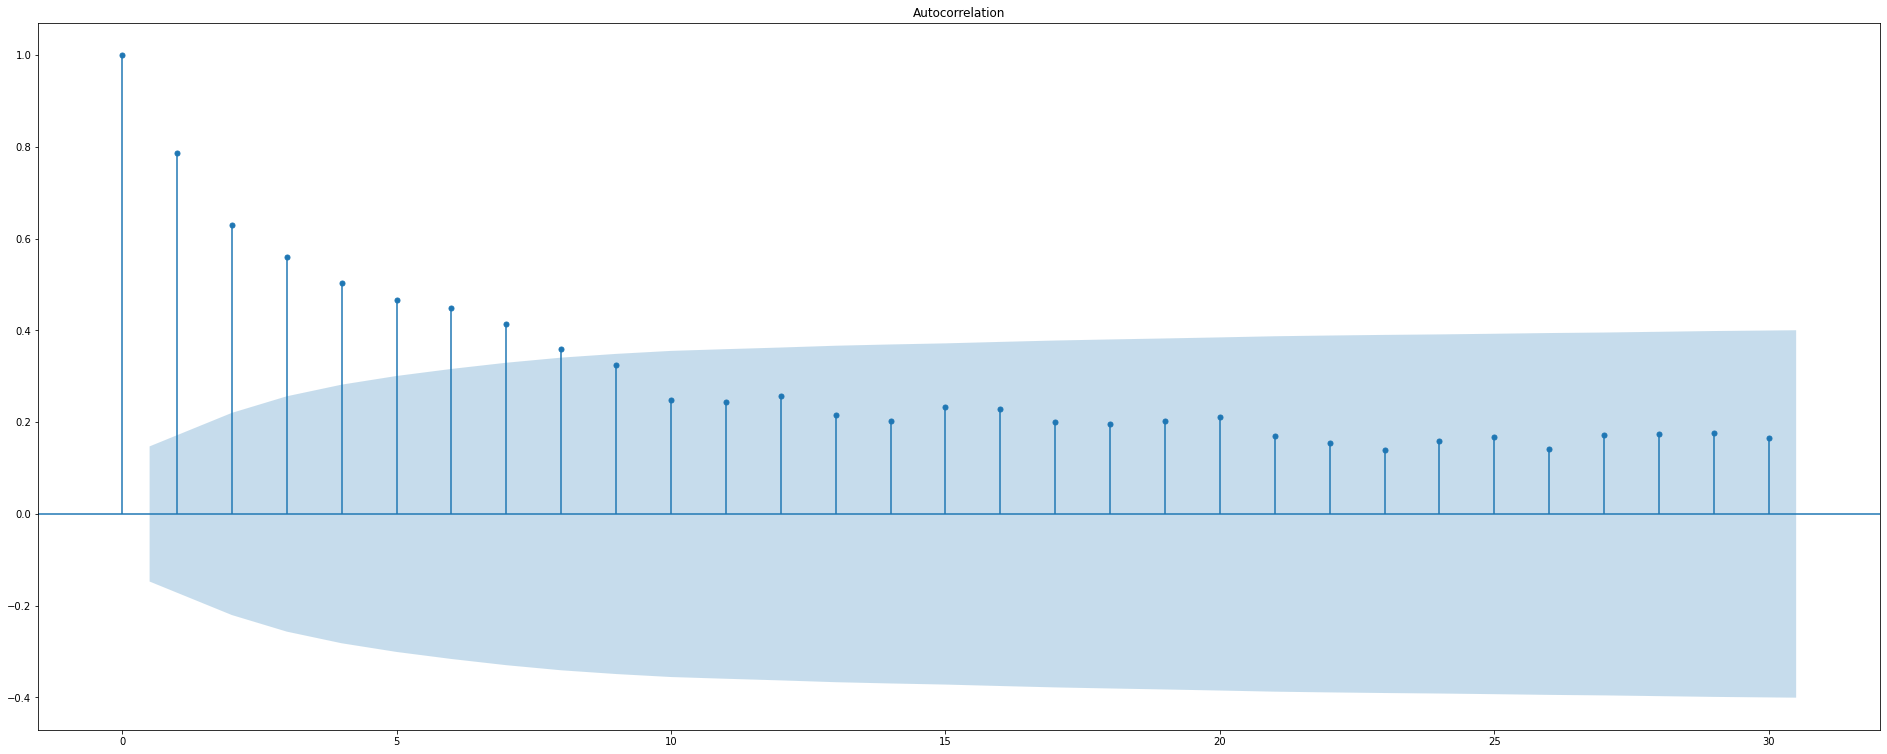

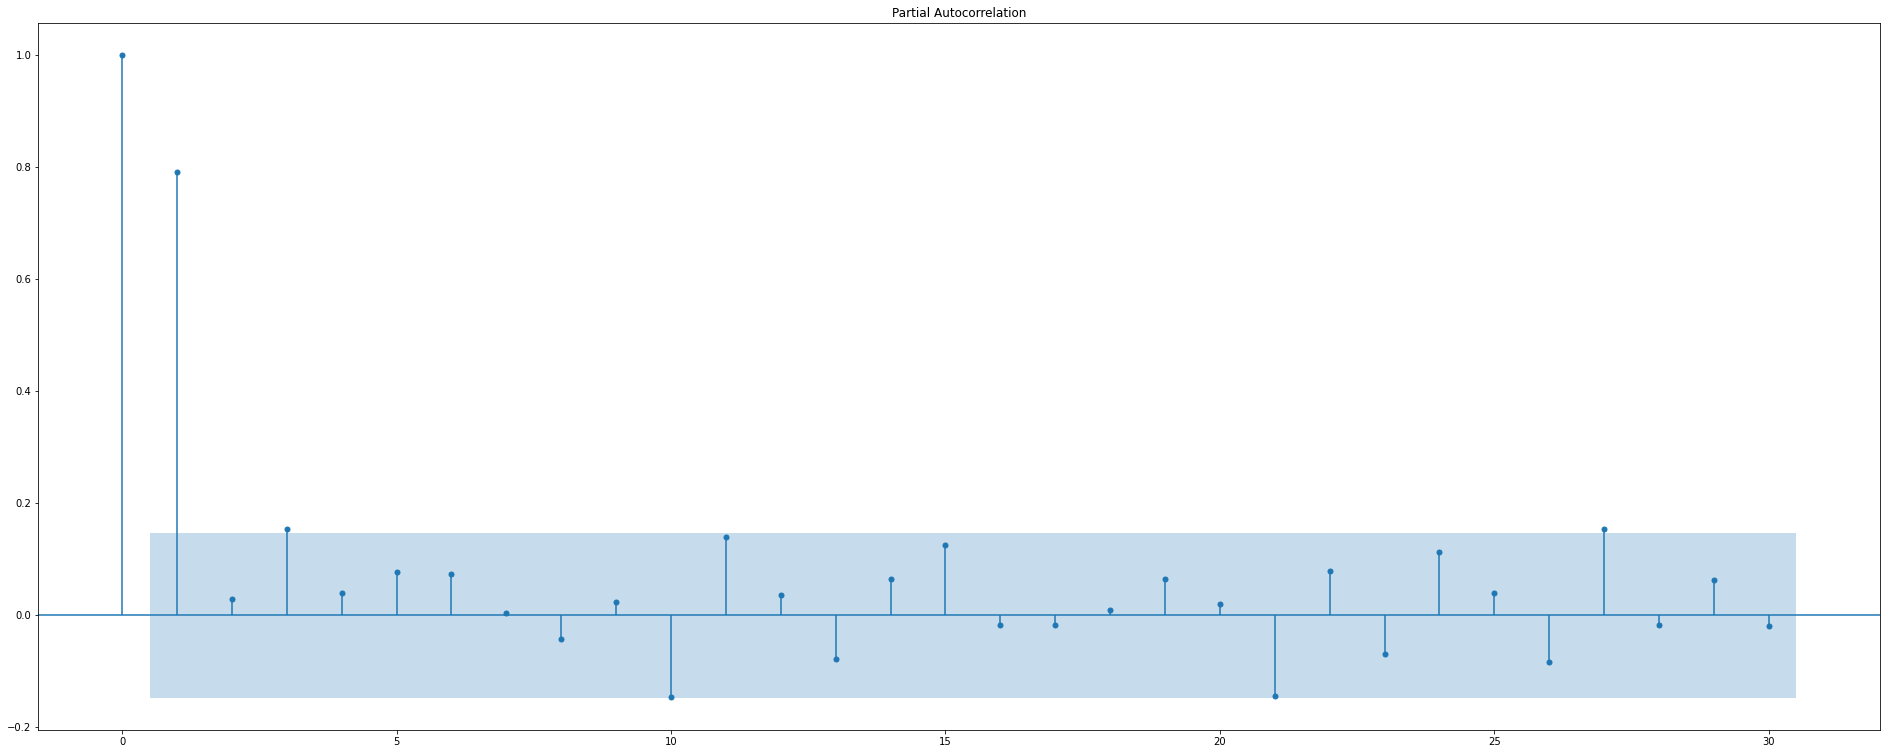

In [11]:
plt.rc("figure", figsize=(33, 13))
plot_acf(y, lags=30)
plt.show()

plt.rc("figure", figsize=(33, 13))
plot_pacf(y, lags=30)
plt.show()

# Autoregressive Moving Average (ARMA)


In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    src_data_model = y[:171]
    model = ARIMA(src_data_model, order=(2, 0, 8))
    model_fit = model.fit()
    yhat_1 =  model_fit.predict(len(src_data_model), len(src_data_model)+5)

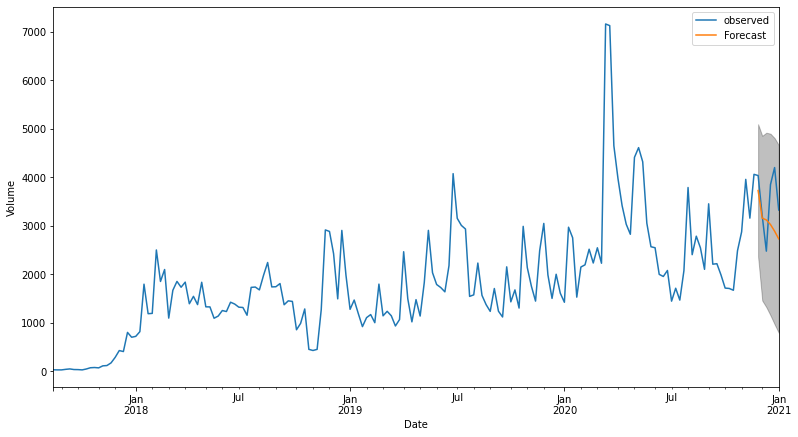

In [13]:
pred_uc = model_fit.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(13, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()
plt.show()

## model analysis and evaluation

In [14]:
print(int(metrics.mae(y[171:], yhat_1)), '- mean absolute error')

621 - mean absolute error


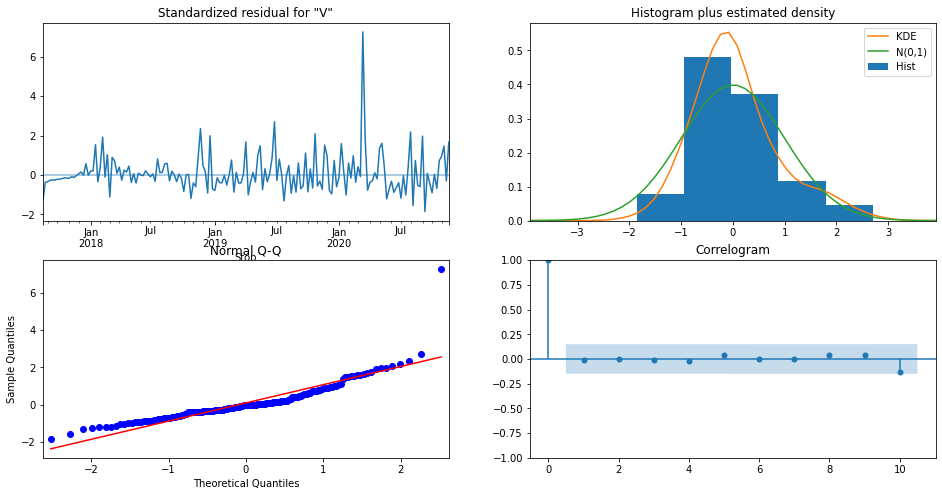

In [15]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

# Autoregressive Integrated Moving Average (ARIMA)

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    src_data_model = y[:171]
    model = ARIMA(src_data_model, order=(2, 0, 8))
    model_fit = model.fit()
    yhat_2 =  model_fit.predict(len(src_data_model), len(src_data_model)+5,  typ='levels')

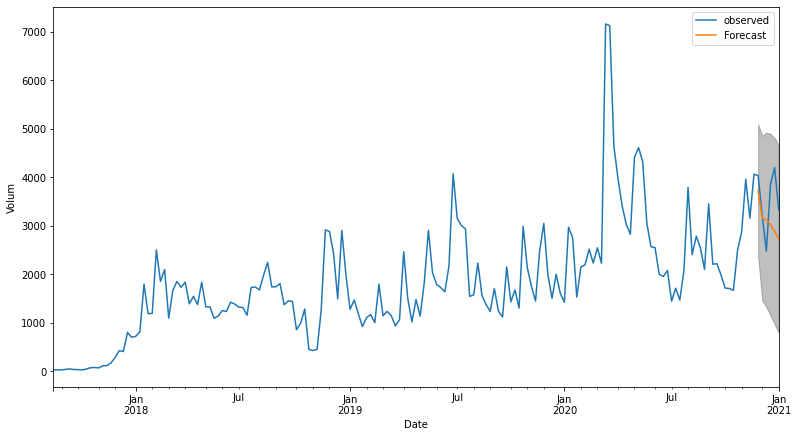

In [17]:
pred_uc = model_fit.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(13, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volum')
plt.legend()
plt.show()

## model analysis and evaluation

In [18]:
print(int(metrics.mae(y[171:], yhat_2)), '- mean absolute error')

621 - mean absolute error


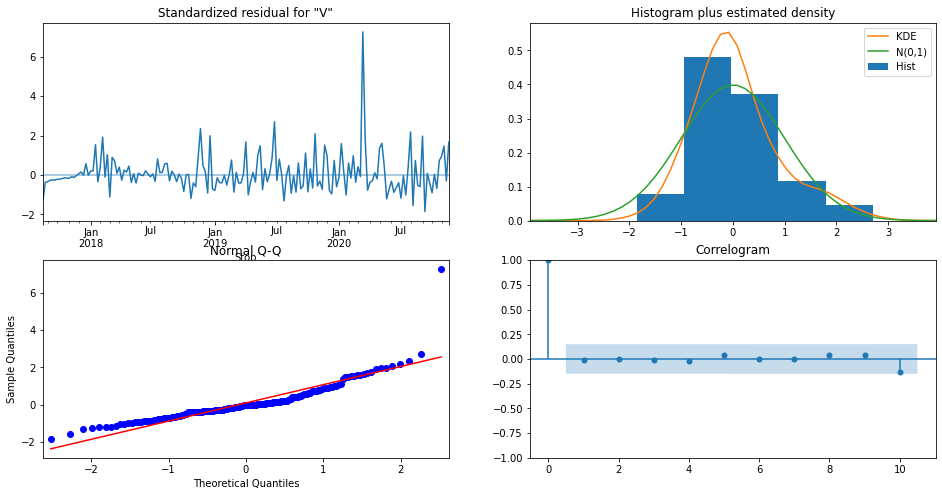

In [19]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

## search parameters 

In [20]:
P = D = Q = range(0, 2)
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(P, D, Q))]

In [21]:
def search_param(seasonal_pdq, best_aic = float("inf"), best_param_seasonal = None):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y[:161],
                                            order=(2, 0, 8),
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            aic =  results.aic
            if aic < best_aic:
                best_aic = aic
                best_param_seasonal = param_seasonal

            # print('ARIMA{}x{}52 - AIC:{}'.format((2, 0, 8), param_seasonal, aic))
        except:
            continue
    # print(best_aic, (2, 0, 8), best_param_seasonal)            
    return best_aic, (2, 0, 8), best_param_seasonal

## process call 

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
   
    best_aic, best_param, best_param_seasonal = search_param(seasonal_pdq)

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    src_data_model = y[:161]
    model = SARIMAX(src_data_model, order=best_param, seasonal_order=best_param_seasonal)
    model_fit = model.fit()
    yhat_3 =  model_fit.predict(len(src_data_model), len(src_data_model)+15)

## drawing graphs

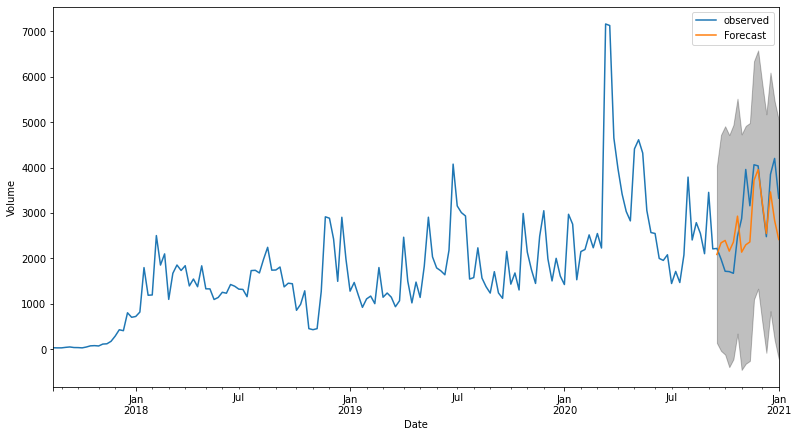

In [24]:
pred_uc = model_fit.get_forecast(steps=16)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(13, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()
plt.show()

## model analysis and evaluation

In [25]:
print(int(metrics.mae(y[161:], yhat_3)), '- mean absolute error')

570 - mean absolute error


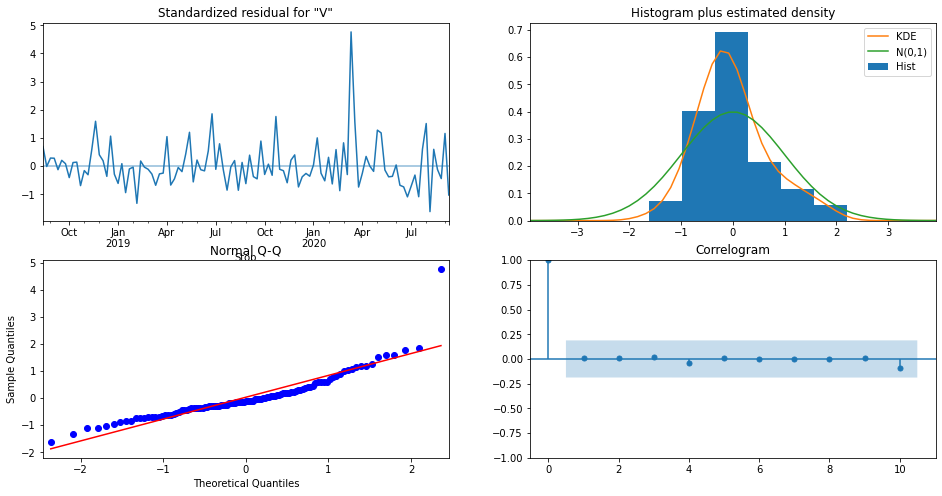

In [26]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()